<a href="https://colab.research.google.com/github/Lipinor/deep_learning_cbpf/blob/master/tarefa_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import PIL
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers, models, layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar
!unrar x "/content/drive/My Drive/Deep_Learning/data/tarefa_4/data_folder.rar" 

A saída de streaming foi truncada nas últimas 5000 linhas.
Extracting  data_folder/6929597574_dc5dd8b10b.jpg                         60%  OK 
Extracting  data_folder/6931532444_f3f1db0b6e.jpg                         60%  OK 
Extracting  data_folder/6938682540_7697a17902.jpg                         60%  OK 
Extracting  data_folder/6938683414_07c2935433.jpg                         60%  OK 
Extracting  data_folder/6938684226_d38a72c32d.jpg                         60%  OK 
Extracting  data_folder/6938688566_4a72e848f7.jpg                         60%  OK 
Extracting  data_folder/6938696766_abb5dd7907.jpg                         60%  OK 
Extracting  data_folder/6938697544_ea0a40b970.jpg                         60%  OK 
Extracting  data_folder/6938704602_024838879c.jpg                         60%  OK 
Extracting  data_folder/6938705546_816070e2b8.jpg                         60%  OK 
Extracting  data_fold

In [ ]:
data_file_path = '/content/drive/My Drive/Deep_Learning/data/tarefa_4/dataset_images_minitest.csv'
df = pd.read_csv(data_file_path,sep='\t')

#df = df.sample(frac=1).reset_index(drop=True)
df.head()

,filename,category
0,1007270_99118848fd.jpg,graduation
1,1007274_075d925378.jpg,graduation
2,1009219698_b40b9e6d87.jpg,graduation
3,10100422_0feca68bfb.jpg,graduation
4,10100587_48faabb61a.jpg,graduation


First, we are going to prepare our data. We need to ensure that the train and validation sets contain an equal distribution of the three image classes.

In [ ]:
from sklearn.model_selection import train_test_split

X = df['filename']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    stratify=y, 
    test_size=0.2, 
    random_state=32)

Now we create the train and test dataframes, and verify if they have an homogeneous distribution of each class:

In [ ]:
train_df = pd.DataFrame(data = {'filename': X_train, 'category': y_train})
test_df = pd.DataFrame(data = {'filename': X_test, 'category': y_test})

print(f"\nDataframe:\n{df['category'].value_counts()}")
print(f"\nTrain Dataset:\n{train_df['category'].value_counts()}")
print(f"\nTest Dataset:\n{test_df['category'].value_counts()}")


Dataframe:
meeting       7000
picnic        6995
graduation    6992
Name: category, dtype: int64

Train Dataset:
meeting       5600
picnic        5596
graduation    5593
Name: category, dtype: int64

Test Dataset:
meeting       1400
graduation    1399
picnic        1399
Name: category, dtype: int64


In [ ]:
images_path = "/content/data_folder"

batch_size = 32
img_size = (64,64)

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

print("Training dataset:")
train_generator = train_datagen.flow_from_dataframe(
        dataframe= train_df,
        directory= images_path,
        x_col="filename",
        y_col="category",
        batch_size=batch_size,
        color_mode="rgb",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size) 

val_datagen = ImageDataGenerator(rescale=1./255)


print("Validation dataset:")
valid_generator = val_datagen.flow_from_dataframe(
        dataframe= test_df,
        directory= images_path,
        x_col="filename",
        y_col="category",
        batch_size=batch_size,
        color_mode="rgb",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size)

Training dataset:
Found 16789 validated image filenames belonging to 3 classes.
Validation dataset:
Found 4198 validated image filenames belonging to 3 classes.


In [ ]:
from keras import layers
from keras import models

num_classes = 3

# Build the model.
model = models.Sequential()
model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu',strides=2,
                        input_shape=img_size + (3,)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, kernel_size=(5, 5), strides=2, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
Dropout(0.3)
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 30, 30, 64)        4864      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 6, 6, 32)          51232     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                18496     
_________________________________________________________________
dense_47 (Dense)             (None, 3)               

In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=valid_generator,
                    validation_steps=step_size_valid,
                    epochs=10
)

Epoch 1/10
524/524 [==============================] - 126s 241ms/step - loss: 0.9983 - accuracy: 0.4924 - val_loss: 0.9118 - val_accuracy: 0.5637
Epoch 2/10
524/524 [==============================] - 122s 232ms/step - loss: 0.9281 - accuracy: 0.5612 - val_loss: 0.8975 - val_accuracy: 0.5646
Epoch 3/10
524/524 [==============================] - 122s 232ms/step - loss: 0.9069 - accuracy: 0.5732 - val_loss: 0.8456 - val_accuracy: 0.6159
Epoch 4/10
524/524 [==============================] - 122s 232ms/step - loss: 0.8811 - accuracy: 0.5925 - val_loss: 0.8430 - val_accuracy: 0.6193
Epoch 5/10
524/524 [==============================] - 121s 231ms/step - loss: 0.8768 - accuracy: 0.5986 - val_loss: 0.8615 - val_accuracy: 0.5997
Epoch 6/10
524/524 [==============================] - 123s 234ms/step - loss: 0.8570 - accuracy: 0.6092 - val_loss: 0.8231 - val_accuracy: 0.6353
Epoch 7/10
524/524 [==============================] - 120s 229ms/step - loss: 0.8508 - accuracy: 0.6138 - val_loss: 0.8400 -

In [ ]:
#@title Função para os plots (la_plots(history))
def la_plots(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    #Epochs
    epochs = range(len(val_loss))

    # Plotting loss
    
    COLOR = 'white'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    

    fig1 = plt.figure(figsize=(8,5))
    gs1 = fig1.add_gridspec(1, 1)
    ax1 = fig1.add_subplot(gs1[0, 0])

    ax1.plot(epochs, loss, 'r-o', label='Training')
    ax1.plot(epochs, val_loss, 'b-o', label='Validation')
    ax1.set_xlabel('Epochs', size=16)
    ax1.set_ylabel('Loss', size=16)
    #ax1.set_yscale('log')
    ax1.legend()
    plt.show()

    # Plotting accuracy metric

    fig2 = plt.figure(figsize=(8,5))
    gs2 = fig2.add_gridspec(1, 1)
    ax2 = fig2.add_subplot(gs2[0, 0])

    ax2.plot(epochs, accuracy, 'r-o', label='Training')
    ax2.plot(epochs, val_accuracy, 'b-o', label='Validation')
    ax2.set_xlabel('Epochs', size=16)
    ax2.set_ylabel('Accuracy', size=16)
    #ax2.set_yscale('log')
    ax2.legend()
    plt.show()

In [ ]:
la_plots(history)

NameError: ignored

Here we plot the ROC curve.

In [ ]:
y = np.array(pd.get_dummies(y_test))

datagen_valid = ImageDataGenerator(rescale=1./255)

valid_dataframe = datagen_valid.flow_from_dataframe(dataframe = test,
                                        directory=images_path, 
                                        target_size=img_size,
                                        shuffle=False,
                                        class_mode=None,
                                        batch_size=32)

Found 4198 validated image filenames.


In [ ]:
y_scores = model.predict(valid_dataframe, verbose=1)

132/132 [==============================] - 18s 133ms/step


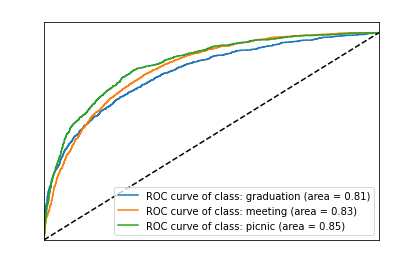

In [ ]:
from sklearn.metrics import roc_curve, auc

classes = ['graduation', 'meeting', 'picnic']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class: {0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve',color='white')
plt.legend(loc="lower right")
plt.show()


#Cross-validation

In [ ]:
pip install -q pyyaml h5py

In [ ]:
data_file_path = '/content/drive/My Drive/Deep_Learning/data/tarefa_4/dataset_images_minitest.csv'
train_data = pd.read_csv(data_file_path,sep='\t')

train_data = train_data.sample(frac=1).reset_index(drop=True)

train_data.head()

,filename,category
0,14474173799_084ebb5357.jpg,graduation
1,9627826844_7f3998e102.jpg,meeting
2,6234791056_48a13a231b.jpg,picnic
3,p012_0168.jpg,picnic
4,g020_0055.jpg,graduation


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

Y = train_data[['category']]
                         
skf = StratifiedKFold(n_splits = 10, random_state = 7, shuffle = True)

n_samples = len(Y)

Create an instance of the ImageDataGenerator class:

In [ ]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

Auxiliary function for getting model name in each of the k iterations:

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0140 - accuracy: 0.4733
Epoch 00001: val_accuracy improved from -inf to 0.54423, saving model to model_1.h5
590/590 [==============================] - 144s 244ms/step - loss: 1.0140 - accuracy: 0.4733 - val_loss: 0.9547 - val_accuracy: 0.5442
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9183 - accuracy: 0.5661
Epoch 00002: val_accuracy improved from 0.54423 to 0.60000, saving model to model_1.h5
590/590 [==============================] - 143s 243ms/step - loss: 0.9183 - accuracy: 0.5661 - val_loss: 0.8656 - val_accuracy: 0.6000
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.5840
Epoch 00003: 

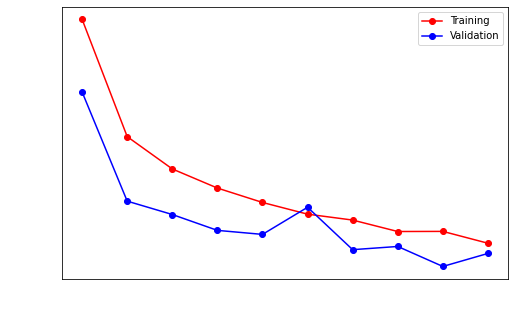

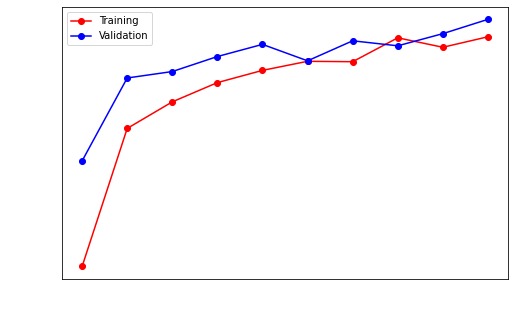

accuracy: 63.79%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.4813
Epoch 00001: val_accuracy improved from -inf to 0.52837, saving model to model_2.h5
590/590 [==============================] - 142s 241ms/step - loss: 1.0123 - accuracy: 0.4813 - val_loss: 0.9658 - val_accuracy: 0.5284
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9248 - accuracy: 0.5630
Epoch 00002: val_accuracy improved from 0.52837 to 0.59087, saving model to model_2.h5
590/590 [==============================] - 144s 244ms/step - loss: 0.9248 - accuracy: 0.5630 - val_loss: 0.9042 - val_accuracy: 0.5909
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.9013 - accuracy: 0.5

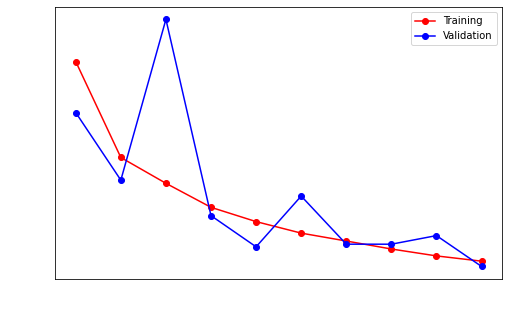

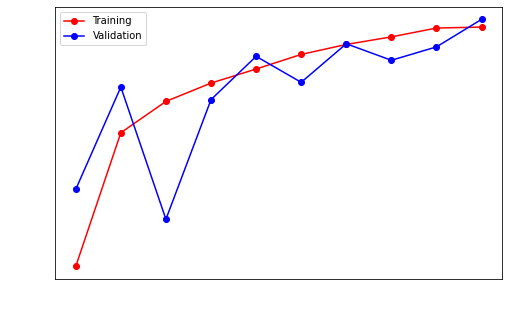

accuracy: 63.27%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.4699
Epoch 00001: val_accuracy improved from -inf to 0.52692, saving model to model_3.h5
590/590 [==============================] - 151s 256ms/step - loss: 1.0172 - accuracy: 0.4699 - val_loss: 0.9650 - val_accuracy: 0.5269
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9279 - accuracy: 0.5572
Epoch 00002: val_accuracy improved from 0.52692 to 0.59615, saving model to model_3.h5
590/590 [==============================] - 148s 251ms/step - loss: 0.9279 - accuracy: 0.5572 - val_loss: 0.8672 - val_accuracy: 0.5962
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8976 - accuracy: 0.5

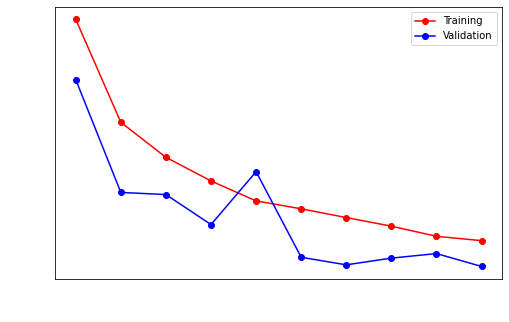

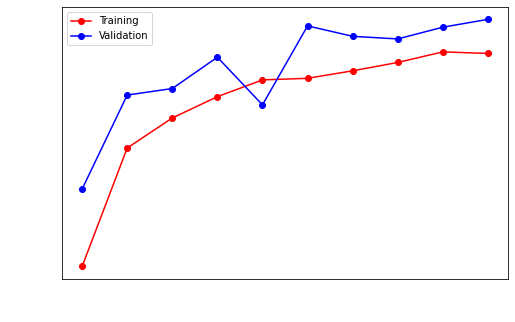

accuracy: 65.32%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.4769
Epoch 00001: val_accuracy improved from -inf to 0.48558, saving model to model_4.h5
590/590 [==============================] - 148s 250ms/step - loss: 1.0128 - accuracy: 0.4769 - val_loss: 0.9922 - val_accuracy: 0.4856
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9316 - accuracy: 0.5519
Epoch 00002: val_accuracy improved from 0.48558 to 0.60913, saving model to model_4.h5
590/590 [==============================] - 146s 248ms/step - loss: 0.9316 - accuracy: 0.5519 - val_loss: 0.8777 - val_accuracy: 0.6091
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.9052 - accuracy: 0.5

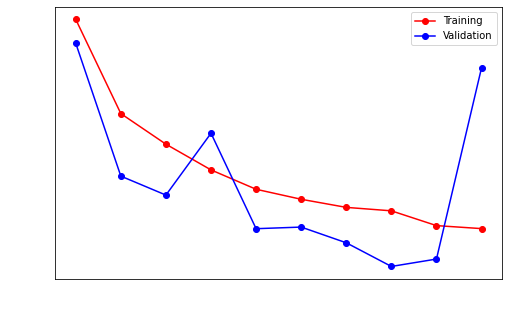

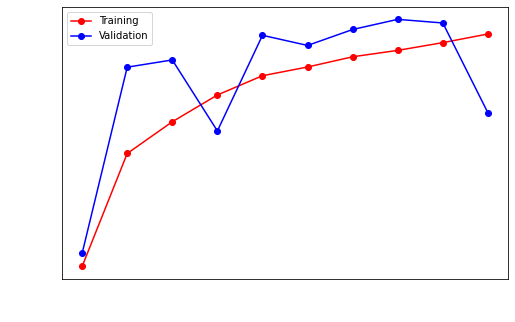

accuracy: 64.22%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 0.9921 - accuracy: 0.4957
Epoch 00001: val_accuracy improved from -inf to 0.57019, saving model to model_5.h5
590/590 [==============================] - 149s 253ms/step - loss: 0.9921 - accuracy: 0.4957 - val_loss: 0.9023 - val_accuracy: 0.5702
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9198 - accuracy: 0.5637
Epoch 00002: val_accuracy improved from 0.57019 to 0.58365, saving model to model_5.h5
590/590 [==============================] - 147s 249ms/step - loss: 0.9198 - accuracy: 0.5637 - val_loss: 0.8741 - val_accuracy: 0.5837
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.5

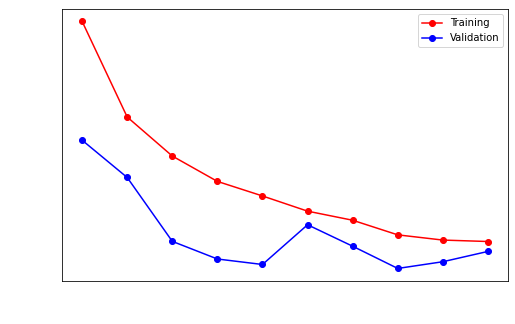

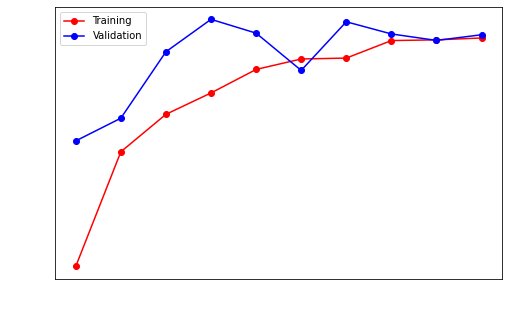

accuracy: 63.98%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0156 - accuracy: 0.4843
Epoch 00001: val_accuracy improved from -inf to 0.55481, saving model to model_6.h5
590/590 [==============================] - 143s 242ms/step - loss: 1.0156 - accuracy: 0.4843 - val_loss: 0.9279 - val_accuracy: 0.5548
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9413 - accuracy: 0.5474
Epoch 00002: val_accuracy improved from 0.55481 to 0.58798, saving model to model_6.h5
590/590 [==============================] - 143s 242ms/step - loss: 0.9413 - accuracy: 0.5474 - val_loss: 0.8870 - val_accuracy: 0.5880
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.5

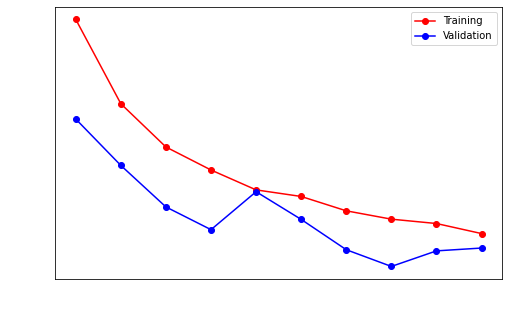

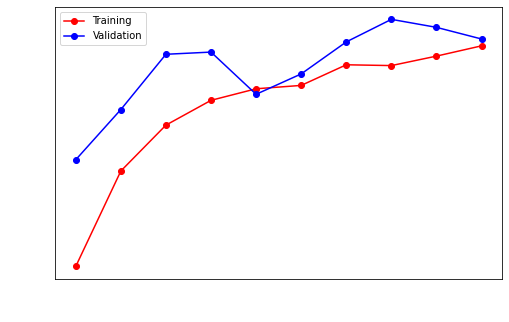

accuracy: 64.70%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0178 - accuracy: 0.4756
Epoch 00001: val_accuracy improved from -inf to 0.51490, saving model to model_7.h5
590/590 [==============================] - 144s 244ms/step - loss: 1.0178 - accuracy: 0.4756 - val_loss: 0.9622 - val_accuracy: 0.5149
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.5578
Epoch 00002: val_accuracy improved from 0.51490 to 0.57163, saving model to model_7.h5
590/590 [==============================] - 146s 248ms/step - loss: 0.9292 - accuracy: 0.5578 - val_loss: 0.8993 - val_accuracy: 0.5716
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8989 - accuracy: 0.5

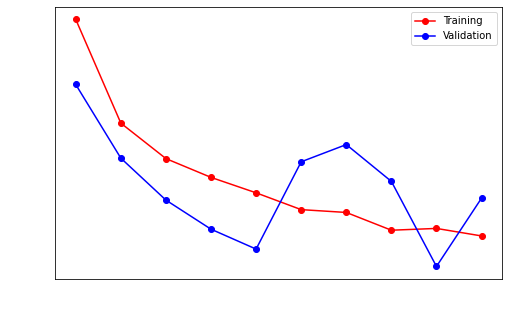

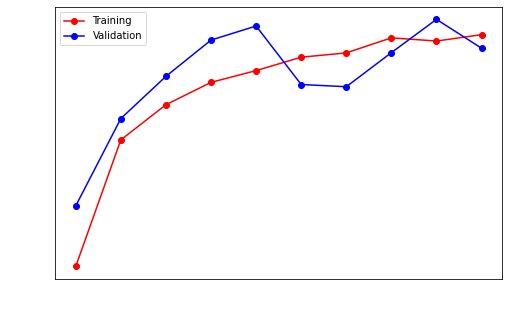

accuracy: 63.74%
Training dataset:
Found 18889 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2098 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0003 - accuracy: 0.4873
Epoch 00001: val_accuracy improved from -inf to 0.59471, saving model to model_8.h5
590/590 [==============================] - 146s 248ms/step - loss: 1.0003 - accuracy: 0.4873 - val_loss: 0.9013 - val_accuracy: 0.5947
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9204 - accuracy: 0.5630
Epoch 00002: val_accuracy did not improve from 0.59471
590/590 [==============================] - 147s 248ms/step - loss: 0.9204 - accuracy: 0.5630 - val_loss: 0.9381 - val_accuracy: 0.5389
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.5806
Epoch 00003: val_accuracy im

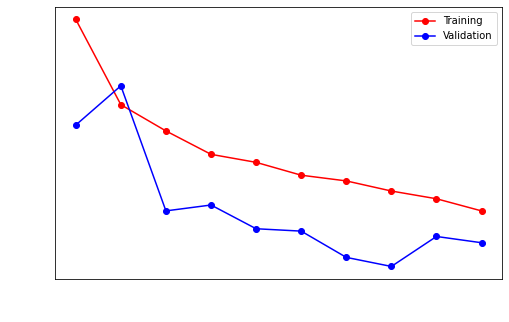

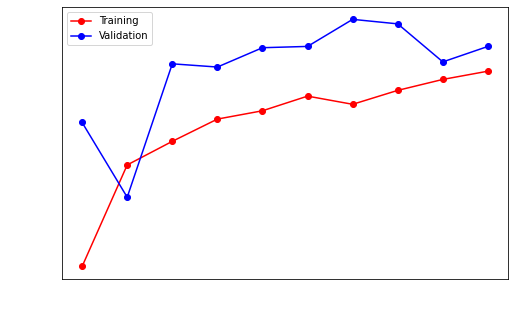

accuracy: 67.06%
Training dataset:
Found 18889 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2098 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0177 - accuracy: 0.4713
Epoch 00001: val_accuracy improved from -inf to 0.55865, saving model to model_9.h5
590/590 [==============================] - 146s 247ms/step - loss: 1.0177 - accuracy: 0.4713 - val_loss: 0.9098 - val_accuracy: 0.5587
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9187 - accuracy: 0.5690
Epoch 00002: val_accuracy improved from 0.55865 to 0.60817, saving model to model_9.h5
590/590 [==============================] - 146s 247ms/step - loss: 0.9187 - accuracy: 0.5690 - val_loss: 0.8703 - val_accuracy: 0.6082
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8949 - accuracy: 0.5

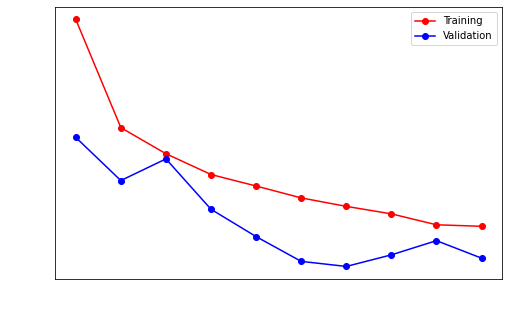

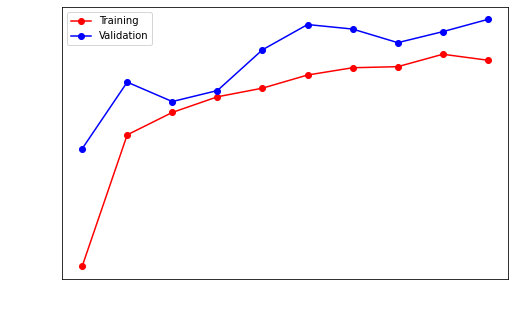

accuracy: 65.44%
Training dataset:
Found 18889 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2098 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0122 - accuracy: 0.4676
Epoch 00001: val_accuracy improved from -inf to 0.55721, saving model to model_10.h5
590/590 [==============================] - 142s 241ms/step - loss: 1.0122 - accuracy: 0.4676 - val_loss: 0.9328 - val_accuracy: 0.5572
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9357 - accuracy: 0.5526
Epoch 00002: val_accuracy improved from 0.55721 to 0.61971, saving model to model_10.h5
590/590 [==============================] - 140s 238ms/step - loss: 0.9357 - accuracy: 0.5526 - val_loss: 0.8503 - val_accuracy: 0.6197
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.9076 - accuracy: 

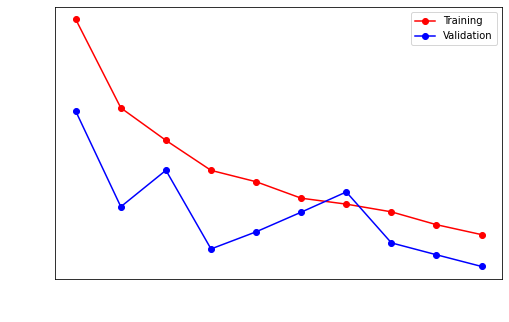

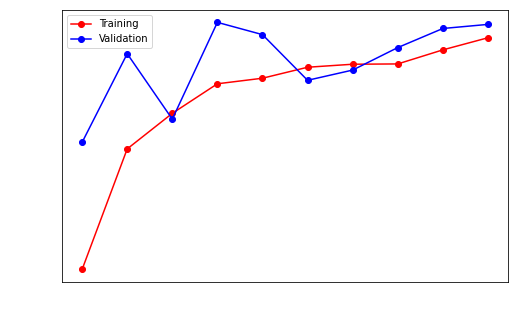

accuracy: 64.01%
64.55% (+/- 1.06%)


In [ ]:
from keras import layers
from keras import models

VALIDATION_ACCURACY = []

#save_dir = '/content/drive/My Drive/Deep_Learning/data/tarefa_4/saved_models/'
save_dir = '/content/'
fold_var = 1

num_classes = 3

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

  print("Training dataset:")
  train_generator = train_datagen.flow_from_dataframe(
        dataframe= training_data,
        directory= images_path,
        x_col="filename",
        y_col="category",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size)

  print("Validation dataset:")
  valid_generator = val_datagen.flow_from_dataframe(
        dataframe= validation_data,
        directory= images_path,
        x_col="filename",
        y_col="category",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size)

  # Build the model.
  model = models.Sequential()
  model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu',strides=2,
                          input_shape=img_size + (3,)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(5, 5), strides=2, activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  Dropout(0.3)
  model.add(layers.Dense(num_classes, activation='softmax'))

  # Compile the model.
  model.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
    
  # Create Callbacks save the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_accuracy', verbose=1, 
              save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  # This saves the best model
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model
  step_size_train=train_generator.n//train_generator.batch_size
  step_size_valid=valid_generator.n//valid_generator.batch_size
  
  history = model.fit_generator(generator=train_generator,
                      steps_per_epoch=step_size_train,
                      validation_data=valid_generator,
                      validation_steps=step_size_valid,
                      epochs=10,
                      callbacks=callbacks_list
  )  

  #PLOT HISTORY
  la_plots(history)

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  scores = model.evaluate(valid_generator, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

  VALIDATION_ACCURACY.append(scores[1] * 100)

  tf.keras.backend.clear_session()

  fold_var += 1

print("%.2f%% (+/- %.2f%%)" % (np.mean(VALIDATION_ACCURACY), np.std(VALIDATION_ACCURACY)))

We got 64.55% of mean accuracy. The model does not seem to be overfitting.

Now let's add a layer Conv+Relu+MaxPoll and see what happens.



Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.4652
Epoch 00001: val_accuracy improved from -inf to 0.58558, saving model to model_1.h5
590/590 [==============================] - 244s 414ms/step - loss: 1.0172 - accuracy: 0.4652 - val_loss: 0.9047 - val_accuracy: 0.5856
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9187 - accuracy: 0.5637
Epoch 00002: val_accuracy did not improve from 0.58558
590/590 [==============================] - 245s 416ms/step - loss: 0.9187 - accuracy: 0.5637 - val_loss: 0.8865 - val_accuracy: 0.5726
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8842 - accuracy: 0.5915
Epoch 00003: val_accuracy improved from 0.585

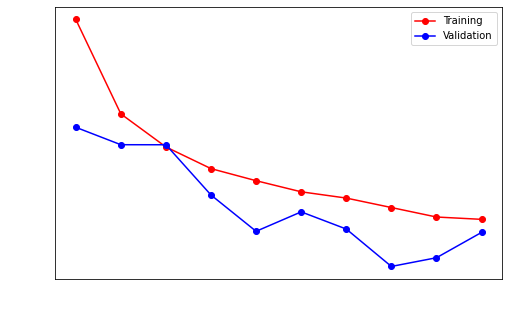

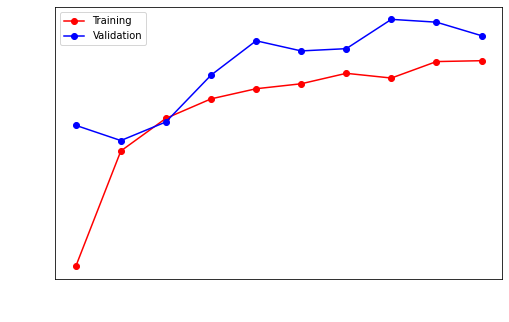

accuracy: 67.75%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0199 - accuracy: 0.4695
Epoch 00001: val_accuracy improved from -inf to 0.55000, saving model to model_2.h5
590/590 [==============================] - 245s 415ms/step - loss: 1.0199 - accuracy: 0.4695 - val_loss: 0.9298 - val_accuracy: 0.5500
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9216 - accuracy: 0.5604
Epoch 00002: val_accuracy improved from 0.55000 to 0.59519, saving model to model_2.h5
590/590 [==============================] - 246s 417ms/step - loss: 0.9216 - accuracy: 0.5604 - val_loss: 0.8594 - val_accuracy: 0.5952
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8812 - accuracy: 0.5

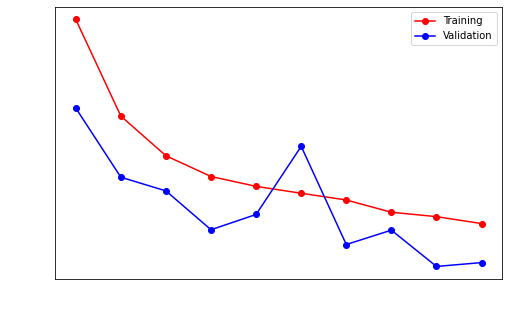

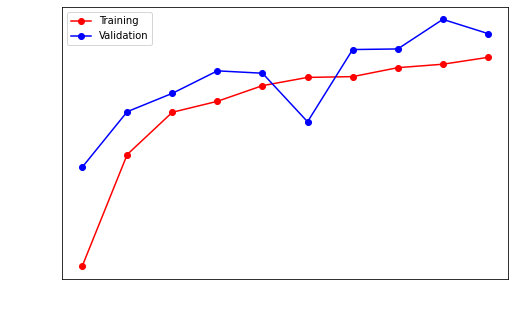

accuracy: 66.79%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0125 - accuracy: 0.4721
Epoch 00001: val_accuracy improved from -inf to 0.56875, saving model to model_3.h5
590/590 [==============================] - 247s 418ms/step - loss: 1.0125 - accuracy: 0.4721 - val_loss: 0.9297 - val_accuracy: 0.5688
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9183 - accuracy: 0.5704
Epoch 00002: val_accuracy improved from 0.56875 to 0.60288, saving model to model_3.h5
590/590 [==============================] - 248s 421ms/step - loss: 0.9183 - accuracy: 0.5704 - val_loss: 0.8521 - val_accuracy: 0.6029
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8744 - accuracy: 0.5

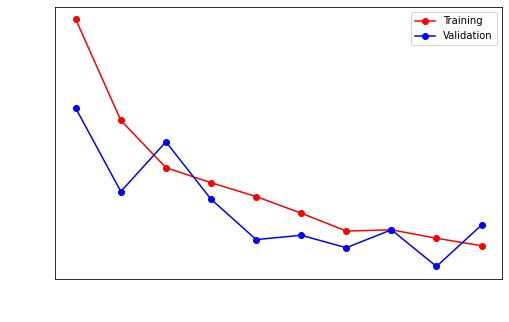

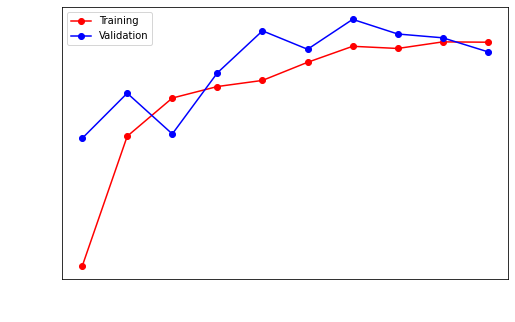

accuracy: 66.03%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0022 - accuracy: 0.4826
Epoch 00001: val_accuracy improved from -inf to 0.56202, saving model to model_4.h5
590/590 [==============================] - 246s 417ms/step - loss: 1.0022 - accuracy: 0.4826 - val_loss: 0.9239 - val_accuracy: 0.5620
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9118 - accuracy: 0.5709
Epoch 00002: val_accuracy improved from 0.56202 to 0.57019, saving model to model_4.h5
590/590 [==============================] - 247s 418ms/step - loss: 0.9118 - accuracy: 0.5709 - val_loss: 0.8791 - val_accuracy: 0.5702
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.5

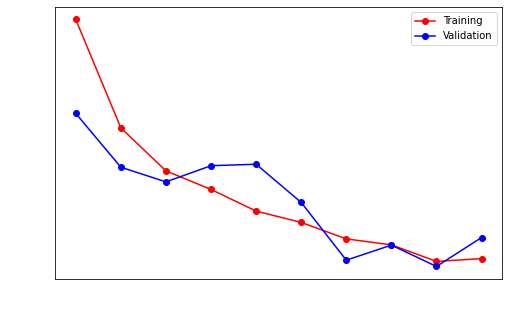

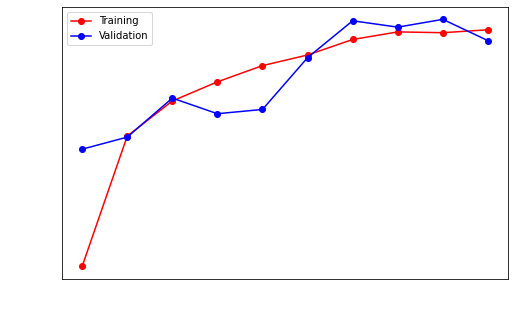

accuracy: 64.98%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0350 - accuracy: 0.4547
Epoch 00001: val_accuracy improved from -inf to 0.52404, saving model to model_5.h5
590/590 [==============================] - 249s 422ms/step - loss: 1.0350 - accuracy: 0.4547 - val_loss: 0.9700 - val_accuracy: 0.5240
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.5601
Epoch 00002: val_accuracy did not improve from 0.52404
590/590 [==============================] - 255s 432ms/step - loss: 0.9344 - accuracy: 0.5601 - val_loss: 0.9863 - val_accuracy: 0.5130
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.5914
Epoch 00003: val_accuracy im

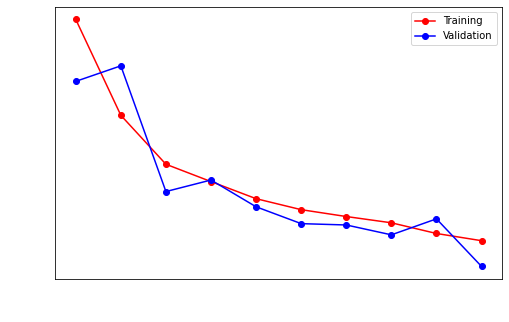

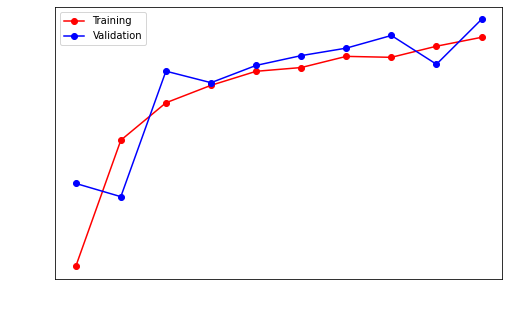

accuracy: 66.32%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0357 - accuracy: 0.4542
Epoch 00001: val_accuracy improved from -inf to 0.54760, saving model to model_6.h5
590/590 [==============================] - 254s 430ms/step - loss: 1.0357 - accuracy: 0.4542 - val_loss: 0.9280 - val_accuracy: 0.5476
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.5562
Epoch 00002: val_accuracy improved from 0.54760 to 0.60096, saving model to model_6.h5
590/590 [==============================] - 252s 426ms/step - loss: 0.9373 - accuracy: 0.5562 - val_loss: 0.8683 - val_accuracy: 0.6010
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8963 - accuracy: 0.5

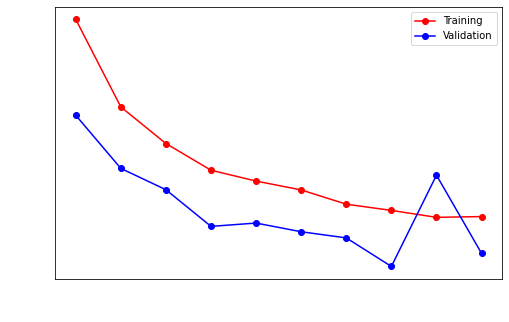

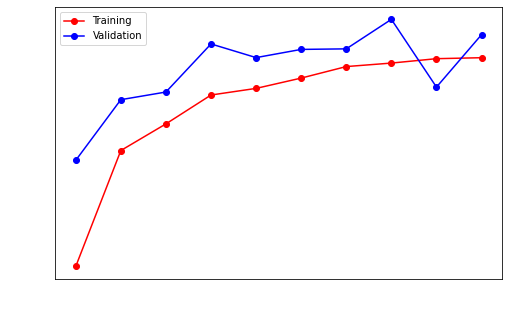

accuracy: 67.22%
Training dataset:
Found 18888 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2099 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0310 - accuracy: 0.4542
Epoch 00001: val_accuracy improved from -inf to 0.54952, saving model to model_7.h5
590/590 [==============================] - 254s 430ms/step - loss: 1.0310 - accuracy: 0.4542 - val_loss: 0.9502 - val_accuracy: 0.5495
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.5530
Epoch 00002: val_accuracy improved from 0.54952 to 0.59808, saving model to model_7.h5
590/590 [==============================] - 251s 426ms/step - loss: 0.9348 - accuracy: 0.5530 - val_loss: 0.8685 - val_accuracy: 0.5981
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8874 - accuracy: 0.5

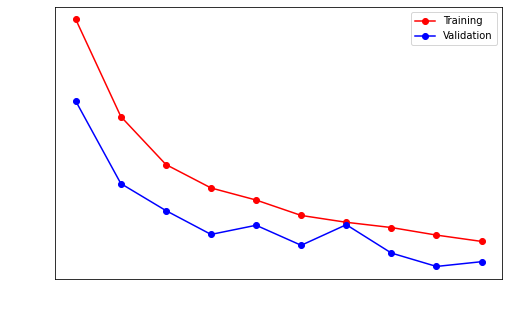

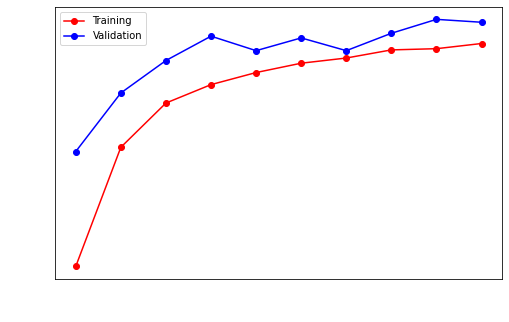

accuracy: 65.94%
Training dataset:
Found 18889 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2098 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0340 - accuracy: 0.4605
Epoch 00001: val_accuracy improved from -inf to 0.53173, saving model to model_8.h5
590/590 [==============================] - 253s 428ms/step - loss: 1.0340 - accuracy: 0.4605 - val_loss: 0.9575 - val_accuracy: 0.5317
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9416 - accuracy: 0.5437
Epoch 00002: val_accuracy improved from 0.53173 to 0.60192, saving model to model_8.h5
590/590 [==============================] - 251s 426ms/step - loss: 0.9416 - accuracy: 0.5437 - val_loss: 0.8532 - val_accuracy: 0.6019
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.9003 - accuracy: 0.5

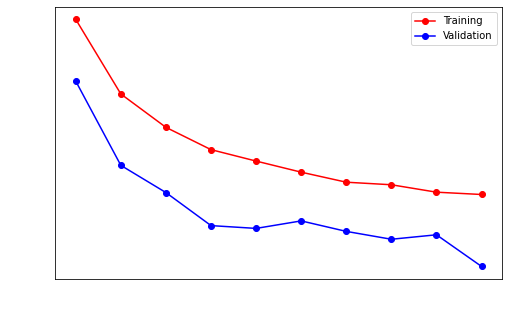

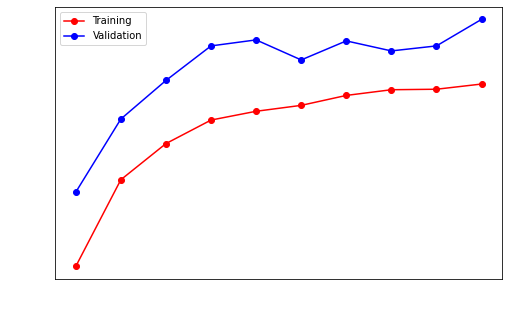

accuracy: 69.73%
Training dataset:
Found 18889 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2098 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0286 - accuracy: 0.4666
Epoch 00001: val_accuracy improved from -inf to 0.55096, saving model to model_9.h5
590/590 [==============================] - 253s 429ms/step - loss: 1.0286 - accuracy: 0.4666 - val_loss: 0.9400 - val_accuracy: 0.5510
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9287 - accuracy: 0.5560
Epoch 00002: val_accuracy improved from 0.55096 to 0.59038, saving model to model_9.h5
590/590 [==============================] - 254s 430ms/step - loss: 0.9287 - accuracy: 0.5560 - val_loss: 0.8970 - val_accuracy: 0.5904
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8858 - accuracy: 0.5

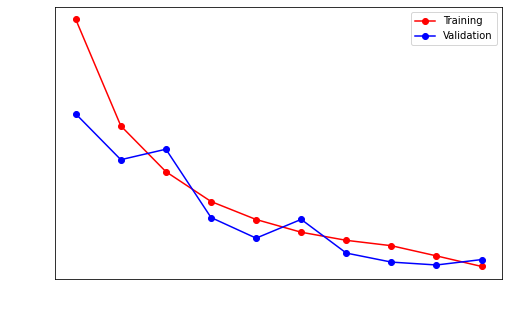

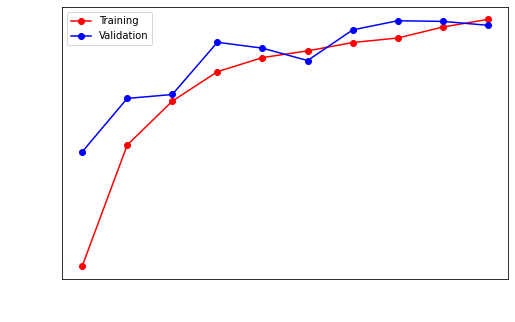

accuracy: 64.63%
Training dataset:
Found 18889 validated image filenames belonging to 3 classes.
Validation dataset:
Found 2098 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/10
590/590 [==============================] - ETA: 0s - loss: 1.0236 - accuracy: 0.4687
Epoch 00001: val_accuracy improved from -inf to 0.56154, saving model to model_10.h5
590/590 [==============================] - 252s 427ms/step - loss: 1.0236 - accuracy: 0.4687 - val_loss: 0.9443 - val_accuracy: 0.5615
Epoch 2/10
590/590 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.5613
Epoch 00002: val_accuracy improved from 0.56154 to 0.57115, saving model to model_10.h5
590/590 [==============================] - 254s 430ms/step - loss: 0.9250 - accuracy: 0.5613 - val_loss: 0.9299 - val_accuracy: 0.5712
Epoch 3/10
590/590 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 

In [30]:
from keras import layers
from keras import models

batch_size = 32
img_size = (128,128)
num_classes = 3

VALIDATION_ACCURACY = []

#save_dir = '/content/drive/My Drive/Deep_Learning/data/tarefa_4/saved_models/'
save_dir = '/content/'
fold_var = 1

num_classes = 3

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]

  print("Training dataset:")
  train_generator = train_datagen.flow_from_dataframe(
        dataframe= training_data,
        directory= images_path,
        x_col="filename",
        y_col="category",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size)

  print("Validation dataset:")
  valid_generator = val_datagen.flow_from_dataframe(
        dataframe= validation_data,
        directory= images_path,
        x_col="filename",
        y_col="category",
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=img_size)

  # Build the model.
  model = models.Sequential()
  model.add(layers.Conv2D(64, kernel_size=(5, 5), activation='relu',strides=2,
                        input_shape=img_size + (3,)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(5, 5), strides=2, activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, kernel_size=(5, 5), strides=2, activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  Dropout(0.3)
  model.add(layers.Dense(num_classes, activation='softmax'))

  # Compile the model.
  model.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
    
  # Create Callbacks save the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_accuracy', verbose=1, 
              save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
  # This saves the best model
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model
  step_size_train=train_generator.n//train_generator.batch_size
  step_size_valid=valid_generator.n//valid_generator.batch_size
  
  history = model.fit_generator(generator=train_generator,
                      steps_per_epoch=step_size_train,
                      validation_data=valid_generator,
                      validation_steps=step_size_valid,
                      epochs=10,
                      callbacks=callbacks_list
  )  

  #PLOT HISTORY
  la_plots(history)

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  scores = model.evaluate(valid_generator, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

  VALIDATION_ACCURACY.append(scores[1] * 100)

  tf.keras.backend.clear_session()

  fold_var += 1

print("%.2f%% (+/- %.2f%%)" % (np.mean(VALIDATION_ACCURACY), np.std(VALIDATION_ACCURACY)))